### Vary dimension $p$
Vary the number of nodes $p$ and observe the error, bias, and time to run.
The number of samples scales with $(p+s) \log p$ for $s$ denoting the sparsity of the precision matrix.

In [17]:
from utils import *
from opt import *
from time import perf_counter

from sklearn.covariance import graphical_lasso

In [18]:
def create_data(p, n, mean_deg, group_prop, psd_fact=.05, weighted_edges=True, w_range=(.5, 1)):
    Z = create_Z(p, group_prop)

    # Create graph
    edge_prob = mean_deg/(p-1)
    A_true = generate_connected_er(p, edge_prob)

    if weighted_edges:
        weights = np.random.uniform(w_range[0], w_range[1], size=A_true.shape)
        weights = np.tril(weights)
        A_true = (weights + weights.T) * A_true

    # Precision matrix as loaded adjacency
    max_eigenval = np.abs(la.eigvalsh(A_true)[0])
    print('Max eigenval:', max_eigenval)
    Theta = (max_eigenval + psd_fact) * np.eye(p) + A_true

    # Create signals
    Sigma = la.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n

    return Sigma_hat, Theta, Z


def run_exp(dim_range, samples_range, data_p, exps, verb=False):
    Thetas_true = []
    Thetas_est = []
    runingtimes = np.zeros((len(dim_range), len(exps)))
    for i, p in enumerate(dim_range):

        print(f'Number of nodes:', p)

        n = samples_range[i]
        Sigma_hat, Theta, Z = create_data(p, n, **data_p)
        Thetas_true.append(Theta)

        Theta_od = Theta*(1-np.eye(p))

        Thetas_est_e = np.zeros((len(exps), p,p))
        for j, exp in enumerate(exps):
            args = exp['args'].copy()

            t_init = perf_counter()
            if exp['model'] == 'glasso':
                args['alpha'] = args['alpha'][i] if isinstance(args['alpha'], list) else args['alpha']
                _, Theta_est = graphical_lasso(Sigma_hat, **args)
            elif exp['model'] == 'fair_flasso':
                args['mu1'] = args['mu1'][i] if isinstance(args['mu1'], list) else args['mu1']
                Theta_est = FairGLASSO_fista(Sigma_hat, Z=Z, **args)
            
            runingtimes[i,j] = perf_counter() - t_init
            Thetas_est_e[j] = Theta_est

            Theta_est_od = Theta_est*(1-np.eye(p))
            err = compute_frob_err(Theta_est_od, Theta_od)
            bias = compute_dp2(Theta_est, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0
            bias_v2 = compute_dp2(Theta_est_od, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0

            if verb:
                print(f'\t{exp["leg"]}: Err: {err:.4f} | Bias: {bias:.5f} | Bias v2: {bias_v2:.5f} | Time: {runingtimes[i,j]:.4f}')

    Thetas_est.append(Thetas_est_e)
        
    return Thetas_est, Thetas_true, runingtimes

In [19]:
# Experiment params
num_trials = 1

DIM_RANGE = [50, 100]
SAMPLE_RANGE = [ int(1e4) for _ in DIM_RANGE ]
num_params = len(DIM_RANGE)
verbose = True

# Graph parameters
data_p = {
    'mean_deg': 5,
    'weighted_edges': True,
    'w_range': (.5, 1),
    'psd_fact': .1,
    'group_prop': [.25, .75],
}


# mu1 = 10/5 # .01
# mu2 = 0  #1000
# epsilon = .1
# bias_type = 'dp'
# eta = .02
# iters = 1000
# EARLY_STOPPING = True
mu1_RANGE = [ 2 * np.log(p)/SAMPLE_RANGE[i] for i,p in enumerate(DIM_RANGE) ] 
print(mu1_RANGE)

Exps = [
    # {'model': 'glasso', 'args': {'alpha': mu1_RANGE, 'max_iter': 1000, 'tol': 1e-6}, 'leg': 'GL'},

    {'model': 'fair_flasso', 'args': {'mu1': mu1_RANGE, 'eta': .02, 'mu2': 0, 'bias_type': 'dp', 
     'tol': 1e-6, 'prec_type': None, 'EARLY_STOP': True}, 'leg': 'FAIR GL, 0'},

    {'model': 'fair_flasso', 'args': {'mu1': mu1_RANGE, 'eta': .02, 'mu2': 0, 'bias_type': 'dp', 
     'tol': 1e-6, 'prec_type': 'non-negative', 'EARLY_STOP': True}, 'leg': 'FAIR GL, 0'},

    {'model': 'fair_flasso', 'args': {'mu1': 1e-5, 'eta': .02, 'mu2': 0, 'bias_type': 'dp', 
     'tol': 1e-6, 'prec_type': None, 'EARLY_STOP': True}, 'leg': 'FAIR GL, 0'},
]

Thetas_est, Thetas_true, runingtimes = run_exp(DIM_RANGE, SAMPLE_RANGE, data_p, Exps, verb=verbose)

[0.0007824046010856292, 0.0009210340371976184]
Number of nodes: 50
Max eigenval: 3.27928612221711
	FAIR GL, 0: Err: 0.0103 | Bias: 0.01181 | Bias v2: 0.01181 | Time: 0.6033
	FAIR GL, 0: Err: 0.0080 | Bias: 0.01174 | Bias v2: 0.01174 | Time: 0.6337
	FAIR GL, 0: Err: 0.0180 | Bias: 0.01093 | Bias v2: 0.01093 | Time: 0.5858
Number of nodes: 100
Max eigenval: 3.613263686837156
	FAIR GL, 0: Err: 8067.5300 | Bias: 0.00580 | Bias v2: 0.00580 | Time: 5.3692
	FAIR GL, 0: Err: 406794.6543 | Bias: 0.31264 | Bias v2: 0.31264 | Time: 5.8728
	FAIR GL, 0: Err: 0.0506 | Bias: 0.00030 | Bias v2: 0.00030 | Time: 4.8510


In [20]:
Theta_glasso_ests = [[None for i in range(num_params)] for t in range(num_trials)]
Theta_glasso_fista_ests = [[None for i in range(num_params)] for t in range(num_trials)]
Theta_dp_ests = [[None for i in range(num_params)] for t in range(num_trials)]
Theta_nodewise_ests = [[None for i in range(num_params)] for t in range(num_trials)]
# Theta_cvxpy_ests = [[None for i in range(num_params)] for t in range(num_trials)]

bias_true = np.zeros((num_trials,num_params))

frob_err_glasso = np.zeros((num_trials,num_params))
f1_score_glasso = np.zeros((num_trials,num_params))
time_run_glasso = np.zeros((num_trials,num_params))
bias_glasso = np.zeros((num_trials,num_params))

frob_err_glasso_fista = np.zeros((num_trials,num_params))
f1_score_glasso_fista = np.zeros((num_trials,num_params))
time_run_glasso_fista = np.zeros((num_trials,num_params))
bias_glasso_fista = np.zeros((num_trials,num_params))

frob_err_dp = np.zeros((num_trials,num_params))
f1_score_dp = np.zeros((num_trials,num_params))
time_run_dp = np.zeros((num_trials,num_params))
bias_dp = np.zeros((num_trials,num_params))

frob_err_nodewise = np.zeros((num_trials,num_params))
f1_score_nodewise = np.zeros((num_trials,num_params))
time_run_nodewise = np.zeros((num_trials,num_params))
bias_nodewise = np.zeros((num_trials,num_params))


for i,p in enumerate(DIM_RANGE):
    n = SAMPLE_RANGE[i]
    mu1 = mu1_RANGE[i]

    for t in range(num_trials):
        print(f"Dimension p = {p} | No. samples n = {n} | Trial {t+1} of {num_trials}")


        # # Create Z
        # z = np.ones(p, dtype=int)
        # z[:int(p/2)] = 0
        # Z = np.eye(g)[z].T
        
        # edge_prob = mean_deg/(p-1)

        # # Create graph
        # A_true = generate_connected_er(p, edge_prob)

        # Precision matrix as loaded adjacency
        # max_eigenval = np.abs(la.eigvalsh(A_true)[0])
        # Theta = (max_eigenval + .05) * np.eye(p) + A_true
        # Sigma = la.inv(Theta)

        # X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
        # Sigma_hat = X.T@X/n

        Sigma_hat, Theta, Z, A_true, p = run_exp(DIM_RANGE, SAMPLE_RANGE, data_p)

        bias_true[t,i] = compute_dp2(Theta,Z)

        # tic = perf_counter()
        # _, Theta_glasso = graphical_lasso(Sigma_hat, alpha=mu1, max_iter=iters, tol=1e-6)
        # Theta_glasso_od = Theta_glasso*(1-np.eye(p))
        # Theta_glasso_ests[t][i] = Theta_glasso.copy()
        # toc = perf_counter()
        # frob_err_glasso[t,i] = compute_frob_err(Theta_glasso_od, A_true)
        # f1_score_glasso[t,i] = compute_f1_score(Theta_glasso, Theta,.1)
        # time_run_glasso[t,i] = np.abs(toc-tic)
        # bias_glasso[t,i] = compute_dp2(Theta_glasso, Z) / np.mean(mat2lowtri(np.abs(Theta_glasso))) if np.mean(mat2lowtri(np.abs(Theta_glasso))) else 0
        # print( '    ' +
        #     'GLASSO: ' + 
        #     f'Err: {frob_err_glasso[t,i]:.4f} | ' +
        #     f'F1: {f1_score_glasso[t,i]:.4f} | ' +
        #     f'Time: {time_run_glasso[t,i]:.4f} | ' +
        #     f'Bias: {bias_glasso[t,i]:.4f}')
        
        tic = perf_counter()
        Theta_glasso_fista = FairGLASSO_fista(Sigma_hat, mu1, eta, 0, Z, 'dp', epsilon, iters, EARLY_STOP=EARLY_STOPPING)
        Theta_glasso_fista_od = Theta_glasso_fista*(1-np.eye(p))
        Theta_glasso_fista_ests[t][i] = Theta_glasso_fista.copy()
        toc = perf_counter()
        frob_err_glasso_fista[t,i] = compute_frob_err(Theta_glasso_fista_od, A_true)
        f1_score_glasso_fista[t,i] = compute_f1_score(Theta_glasso_fista, Theta,.1)
        time_run_glasso_fista[t,i] = np.abs(toc-tic)
        # bias_glasso[t,i] = compute_dp2(Theta_glasso_fista, Z) 
        bias_glasso_fista[t,i] = compute_dp2(Theta_glasso_fista, Z) / np.mean(mat2lowtri(np.abs(Theta_glasso_fista))) if np.mean(mat2lowtri(np.abs(Theta_glasso_fista))) else 0
        print( '    ' +
            'GLASSO FISTA: ' + 
            f'Err: {frob_err_glasso_fista[t,i]:.4f} | ' +
            f'F1: {f1_score_glasso_fista[t,i]:.4f} | ' +
            f'Time: {time_run_glasso_fista[t,i]:.4f} | ' +
            f'Bias: {bias_glasso_fista[t,i]:.4f}')

        # tic = perf_counter()
        # Theta_dp = FairGLASSO_fista(Sigma_hat, mu1, eta, mu2, Z, 'dp', epsilon, iters, EARLY_STOP=EARLY_STOPPING)
        # Theta_dp_od = Theta_dp*(1-np.eye(p))
        # Theta_dp_ests[t][i] = Theta_dp.copy()
        # toc = perf_counter()
        # frob_err_dp[t,i] = compute_frob_err(Theta_dp_od, Theta_od)
        # f1_score_dp[t,i] = compute_f1_score(Theta_dp, Theta,.1)
        # time_run_dp[t,i] = np.abs(toc-tic)
        # # bias_dp[t,i] = compute_dp2(Theta_dp, Z) 
        # bias_dp[t,i] = compute_dp2(Theta_dp, Z) / np.mean(mat2lowtri(np.abs(Theta_dp))) if np.mean(mat2lowtri(np.abs(Theta_dp))) else 0
        # print( '    ' +
        #     'DP:     ' + 
        #     f'Err: {frob_err_dp[t,i]:.4f} | ' +
        #     f'F1: {f1_score_dp[t,i]:.4f} | ' +
        #     f'Time: {time_run_dp[t,i]:.4f} | ' +
        #     f'Bias: {bias_dp[t,i]:.4f}')

        # tic = perf_counter()
        # Theta_nodewise = FairGLASSO_fista(Sigma_hat, mu1, eta, mu2, Z, 'nodewise', epsilon, iters, EARLY_STOP=EARLY_STOPPING)
        # Theta_nodewise_od = Theta_nodewise*(1-np.eye(p))
        # Theta_nodewise_ests[t][i] = Theta_nodewise.copy()
        # toc = perf_counter()
        # frob_err_nodewise[t,i] = compute_frob_err(Theta_nodewise_od, Theta_od)
        # f1_score_nodewise[t,i] = compute_f1_score(Theta_nodewise, Theta,.1)
        # time_run_nodewise[t,i] = np.abs(toc-tic)
        # # bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z) 
        # bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z) / np.mean(mat2lowtri(np.abs(Theta_nodewise))) if np.mean(mat2lowtri(np.abs(Theta_nodewise))) else 0
        # print( '    ' +
        #     'Nw. DP: ' + 
        #     f'Err: {frob_err_nodewise[t,i]:.4f} | ' +
        #     f'F1: {f1_score_nodewise[t,i]:.4f} | ' +
        #     f'Time: {time_run_nodewise[t,i]:.4f} | ' +
        #     f'Bias: {bias_nodewise[t,i]:.4f}')


Dimension p = 50 | No. samples n = 10000 | Trial 1 of 1


TypeError: run_exp() missing 1 required positional argument: 'exps'

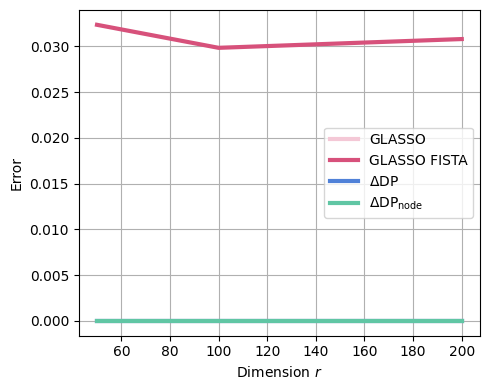

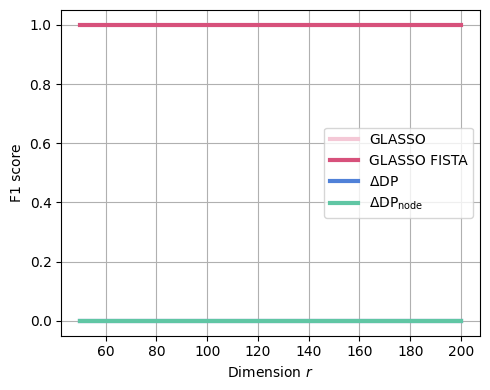

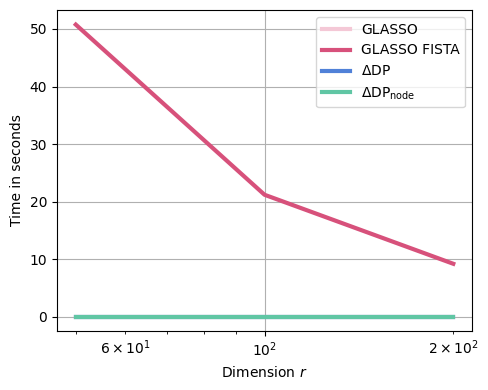

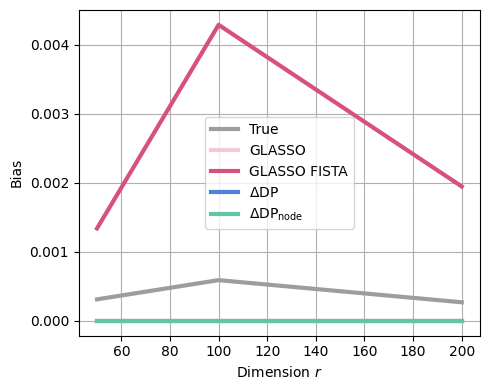

In [ ]:
x_label = r'Dimension $r$'
x_range = DIM_RANGE

plt_args = { 'linewidth':3 }

y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

# y_range = frob_err_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = frob_err_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[1], **plt_args, label='GLASSO')

y_range = frob_err_glasso_fista.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO FISTA')

y_range = frob_err_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = frob_err_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()



y_label = 'F1 score'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

# y_range = f1_score_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = f1_score_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[1], **plt_args, label='GLASSO')

y_range = f1_score_glasso_fista.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO FISTA')

y_range = f1_score_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = f1_score_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Time in seconds'
clr = greens[10]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

# y_range = time_run_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = time_run_glasso.mean(0)
ax.semilogx(x_range, y_range, c=reds[1], **plt_args, label='GLASSO')

y_range = time_run_glasso_fista.mean(0)
ax.semilogx(x_range, y_range, c=reds[10], **plt_args, label='GLASSO FISTA')

y_range = time_run_dp.mean(0)
ax.semilogx(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = time_run_nodewise.mean(0)
ax.semilogx(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = bias_true.mean(0)
ax.plot(x_range, y_range, c=grays[10], **plt_args, label='True')

# y_range = bias_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = bias_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[1], **plt_args, label='GLASSO')

y_range = bias_glasso_fista.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO FISTA')

y_range = bias_dp.mean(0)
# y_range = bias_dp.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = bias_nodewise.mean(0)
# y_range = bias_nodewise.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

